In [17]:
import warnings # Omitir mensajes de advertencia
warnings.filterwarnings("ignore")

In [27]:
# Trabajamos en colab:
from google.colab import drive
drive.mount('/content/drive/')

import os

path = '/content/drive/MyDrive/Colab Notebooks/LessonGH/'

os.chdir(path)

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import calendar
from scipy.stats import gamma, norm
import matplotlib.ticker as mticker
import matplotlib.dates as mdates
from scipy import stats as st

### Standardized Precipitation Index (SPI)
* [Fuente](https://www.sciencedirect.com/topics/agricultural-and-biological-sciences/standardized-precipitation-index#:~:text=The%20SPI%20describes%20the%20amount,and%2012-month%20periods)

---









In [20]:
def calculate_spi(df, spi_type=1, start_date='1981-01', end_date='2010-12'):
    df_copy = df.copy()
    start_date = pd.to_datetime(start_date)
    end_date = pd.to_datetime(end_date)
    df_copy['time'] = pd.date_range(start_date, end_date, freq='MS')
    df_copy.set_index('time', inplace=True)
    data_idx = df_copy[['pp']]
    # Calcular la media móvil según el tipo de SPI
    if (spi_type == 1):
        data_idx[f'pp_spi{spi_type}'] = data_idx['pp']
    else:
        data_idx[f'pp_spi{spi_type}'] = data_idx['pp'].rolling(window=spi_type).mean()

    data_idx_spi = data_idx[[f'pp_spi{spi_type}']]

    # Crear un diccionario para almacenar los DataFrames de cada mes
    meses = {calendar.month_abbr[mes_num].lower(): data_idx_spi[data_idx_spi.index.month == mes_num].reset_index(drop=True)
             for mes_num in range(1, 13)}

    for mes_num, mes in meses.items():
        mes.rename(columns={f'pp_spi{spi_type}': f'pp{mes_num}_spi{spi_type}'}, inplace=True)

    data_piv = pd.concat(meses.values(), axis=1)
    data_piv = data_piv.replace(0, np.nan)

    # Calcular el logaritmo natural de las columnas
    for columna in data_piv.columns:
        data_piv[f'Ln_{columna}'] = np.log(data_piv[columna])

    prom_columns = data_piv.filter(regex=f'^pp').mean().to_numpy()
    Sum_Ln_Columns = data_piv.filter(regex='^Ln_').sum().to_numpy()
    n = data_piv.filter(regex=f'^pp').count().to_numpy()
    A = np.log(prom_columns) - Sum_Ln_Columns / n
    a = (1 / (4 * A)) * (1 + np.sqrt(1 + (4 * A) / 3))
    b = prom_columns / a
    t = len(data_piv)
    q = (t-n)/t if spi_type==1 else np.concatenate(((t-1-n[:spi_type-1])/(t-1),(t-n[spi_type-1:])/t))

    gamma_cdf = np.nan_to_num(gamma.cdf(data_piv.filter(regex=f'^pp'), a, scale=b), nan=0)
    gamma_2_flatt = (q + (1 - q) * gamma_cdf).flatten()

    if spi_type > 1:
        gamma_2_flatt[:spi_type - 1] = np.nan

    SPI = norm.ppf(gamma_2_flatt, loc=0, scale=1)
    SPI_df = pd.DataFrame({f'SPI_[{spi_type}]': SPI})

    # Categorizar los valores de SPI
    def categorize_spi(value):
        if value <= -2:
            return 'extremely drought'
        elif value <= -1.5:
            return 'severely drought'
        elif value <= -1:
            return 'moderately drought'
        elif value <= 1:
            return 'near normal'
        elif value <= 1.5:
            return 'moderately wet'
        elif value <= 2:
            return 'very wet'
        elif value > 2:
            return 'extremely wet'
        else:
            return np.nan

    # df_pp_spi = df['pp'].rolling(window=spi_type).mean().rename(f'pp_SPI_{spi_type}') #(optional)
    SPI_df[f'Categ[SPI_{spi_type}]'] = SPI_df[f'SPI_[{spi_type}]'].apply(categorize_spi)
    # df_result = pd.concat([df, df_pp_spi, SPI_df], axis=1) #(optionl)
    df_result = pd.concat([SPI_df], axis=1)
    return df_result

In [21]:
# # (optional)
# df = pd.read_excel(path + 'DataGH/Chuquibambilla_Puno.xlsx')
# start_date='1981-01'
# end_date='2010-12'
# df_spi = calculate_spi(df, spi_type=1, start_date=start_date, end_date=end_date)
# df_spi

In [22]:
df = pd.read_excel(path + 'DataGH/Chuquibambilla_Puno.xlsx')
start_date='1956-01'
end_date='2013-12'
spi_type_range = [1,3,6,12] # Aquí el SPI
df_spi = pd.concat([calculate_spi(df, spi_type=i, start_date=start_date, end_date=end_date) for i in spi_type_range], axis=1)
df_spi

,SPI_[1],Categ[SPI_1],SPI_[3],Categ[SPI_3],SPI_[6],Categ[SPI_6],SPI_[12],Categ[SPI_12]
0,-0.118232,near normal,NaN,NaN,NaN,NaN,NaN,NaN
1,-1.183995,moderately drought,NaN,NaN,NaN,NaN,NaN,NaN
2,-2.442516,extremely drought,-1.813308,severely drought,NaN,NaN,NaN,NaN
3,-2.130174,extremely drought,-2.853384,extremely drought,NaN,NaN,NaN,NaN
4,-0.236710,near normal,-2.882158,extremely drought,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
691,0.576161,near normal,1.298135,moderately wet,0.151076,near normal,1.249711,moderately wet
692,-0.817937,near normal,-0.140012,near normal,-0.227129,near normal,1.151791,moderately wet
693,0.522719,near normal,0.114660,near normal,0.392238,near normal,1.467428,moderately wet
694,-0.522529,near normal,-0.402618,near normal,-0.017647,near normal,1.004683,moderately wet


In [23]:
time = pd.date_range(start_date, end_date, freq='MS')
df_spi['time'] = time
df_spi.set_index('time', inplace = True)
df_spi

,SPI_[1],Categ[SPI_1],SPI_[3],Categ[SPI_3],SPI_[6],Categ[SPI_6],SPI_[12],Categ[SPI_12]
time,,,,,,,,
1956-01-01,-0.118232,near normal,NaN,NaN,NaN,NaN,NaN,NaN
1956-02-01,-1.183995,moderately drought,NaN,NaN,NaN,NaN,NaN,NaN
1956-03-01,-2.442516,extremely drought,-1.813308,severely drought,NaN,NaN,NaN,NaN
1956-04-01,-2.130174,extremely drought,-2.853384,extremely drought,NaN,NaN,NaN,NaN
1956-05-01,-0.236710,near normal,-2.882158,extremely drought,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
2013-08-01,0.576161,near normal,1.298135,moderately wet,0.151076,near normal,1.249711,moderately wet
2013-09-01,-0.817937,near normal,-0.140012,near normal,-0.227129,near normal,1.151791,moderately wet
2013-10-01,0.522719,near normal,0.114660,near normal,0.392238,near normal,1.467428,moderately wet


In [24]:
custom_order = ['extremely wet', 'very wet', 'moderately wet', 'near normal',
                'moderately drought', 'severely drought', 'extremely drought']
categ_columns = df_spi.filter(like='Categ[SPI_')
category_percentage_df = categ_columns.apply(lambda x: x.value_counts(normalize=True) * 100)
category_percentage_df = category_percentage_df.reindex(custom_order)
category_percentage_df = category_percentage_df.T.reset_index(drop=True)
category_percentage_df.index = categ_columns.columns
category_percentage_df.columns = custom_order
category_percentage_df

,extremely wet,very wet,moderately wet,near normal,moderately drought,severely drought,extremely drought
Categ[SPI_1],2.586207,4.166667,8.333333,74.281609,6.752874,2.155172,1.724138
Categ[SPI_3],1.729107,4.610951,9.510086,70.317003,8.069164,3.746398,2.017291
Categ[SPI_6],1.302460,5.209841,9.117221,68.162084,8.683068,4.630970,2.894356
Categ[SPI_12],0.729927,6.131387,9.635036,68.175182,8.029197,4.379562,2.919708


### Gráfico

In [25]:
def plot_spi(df_spi, category_percentage_df):
    spi_columns = [col for col in df_spi.columns if 'SPI_[' in col]
    for column in spi_columns:
        fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
        # Gráfico de línea en ax1
        ax1.fill_between(df_spi.index, df_spi[column], where=df_spi[column] > 0, color='blue')
        ax1.fill_between(df_spi.index, df_spi[column], where=df_spi[column] < 0, color='red')
        ax1.xaxis.set_major_locator(mdates.YearLocator(3))
        ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
        ax1.set_ylabel(f'{column}', fontsize=10)
        ax1.grid(linewidth=1, color='dimgrey', linestyle='--', alpha=0.75)
        plt.sca(ax1)
        plt.xticks(rotation=45, fontsize=8)
        plt.yticks(fontsize=8)

        # Gráfico de barras horizontales en ax2
        category_row = category_percentage_df.loc[column.replace('SPI_[', 'Categ[SPI_')]
        colors = ['red' if 'wet' in cat else 'blue' if 'drought' in cat else 'lightblue' for cat in category_percentage_df.columns]
        category_row.plot(kind='barh', color=colors, ax=ax2)
        ax2.set_xlim(0, 100)
        # Porcentaje en cada barra
        for i in ax2.patches:
            ax2.text(i.get_width() + 1, i.get_y() + i.get_height() / 2,
                     f'{i.get_width():.2f}%',
                     ha='left', va='center', fontsize=8, color='black')
        plt.sca(ax2)
        plt.xticks(fontsize=8)
        plt.yticks(fontsize=8)
        ax2.grid(linewidth=1, color='dimgrey', linestyle='--', alpha=0.75)

        plt.tight_layout()
        plt.show()

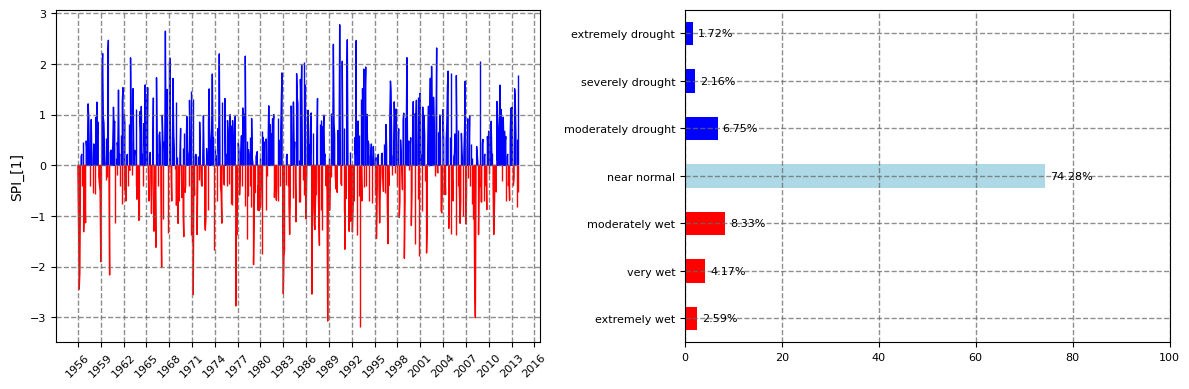

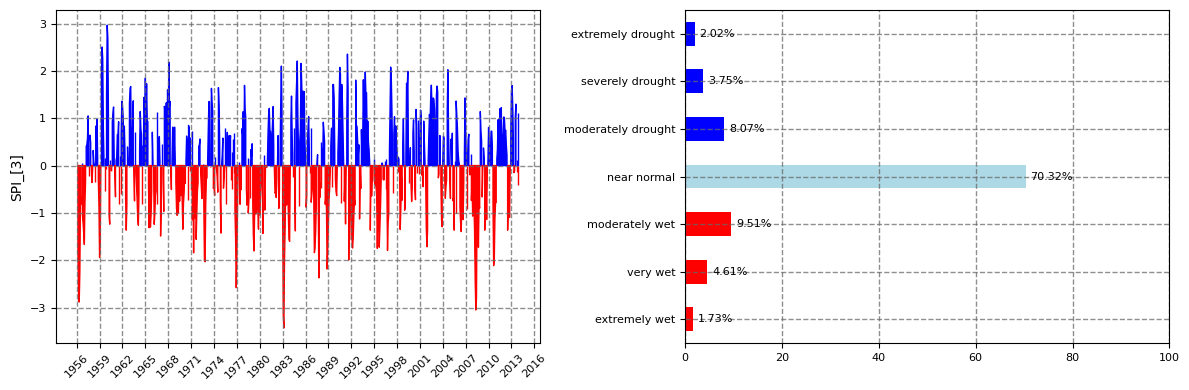

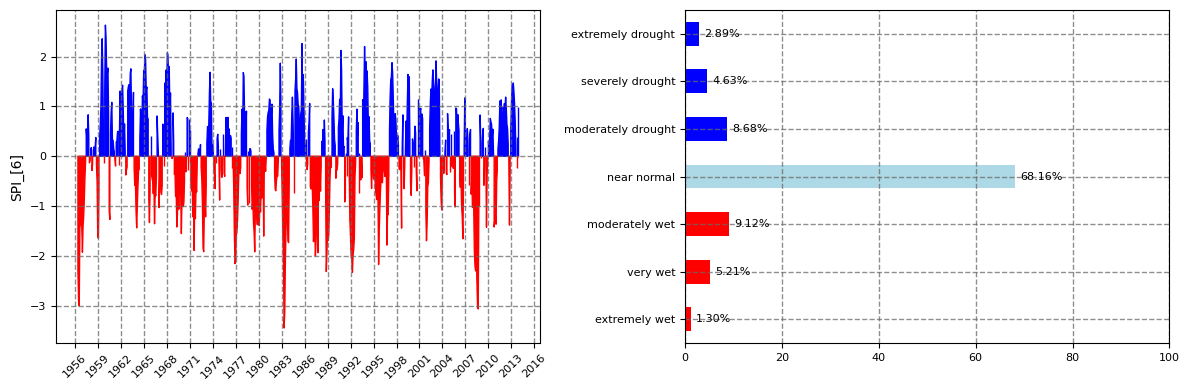

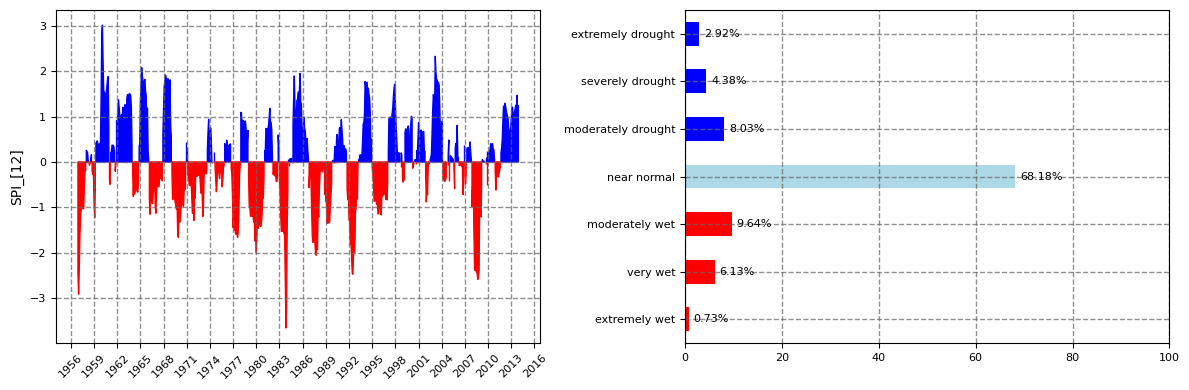

In [26]:
plot_spi(df_spi, category_percentage_df)